In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import sys
import pandas as pd
import re
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
def label_to_count(labels):

    label_to_count_dict = {}
    for label in labels:
        if label not in label_to_count_dict:
            label_to_count_dict[label] = 0
        label_to_count_dict[label] += 1
    return label_to_count_dict


def prepare_data(seqs):
    
    max_len = 0
    
    # build up a voc2ind (letters:token)
    # based on ATGC and include padding and unknown tokens
    voc2ind = {voc:ind for ind,voc in enumerate(['<pad>', '<unk>', 'A', 'T', 'C', 'G'])}
    
    i = len(voc2ind)
    
    # tokenize the sequences
    tokenized_seqs = []
    for seq in seqs:
        tokenized_seq = []
        for e in seq:
            # make sure the sequence is upper case, a == A
            # seq = seq.upper()
            # if we haven't seen this letter before, add to the corupus
            if not e in voc2ind:
                voc2ind[e] = i
                i += 1
            tokenized_seq.append(voc2ind[e])
        tokenized_seqs.append(tokenized_seq)
        
    return tokenized_seqs, voc2ind
        
res = prepare_data(['ATCG', 'TAGA', 'APO'])
print(res)
assert(res[0] == [[2, 3, 4, 5], [3, 2, 5, 2], [2, 6, 7]]), res[0]


def prepare_labels(labels):
    
    tokenized_labels = []
    label2token = {}
    i = 0
    for label in labels:
        if not label in label2token:
            label2token[label] = i
            i += 1
        tokenized_labels.append(label2token[label])
    return tokenized_labels, label2token


def pad(tokenized_seqs, voc2ind):
    
    padded_seqs = []
    
    # find max sequence length
    max_len = 0
    for seq in tokenized_seqs:
        max_len = max(len(seq), max_len)
    
    # add padding so sequences are max_length
    for seq in tokenized_seqs:
        padded_seq = seq + [voc2ind['<pad>']] * (max_len - len(seq))
        padded_seqs.append(padded_seq)
        
    return np.array(padded_seqs, dtype=np.float32)


def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

([[2, 3, 4, 5], [3, 2, 5, 2], [2, 6, 7]], {'<pad>': 0, '<unk>': 1, 'A': 2, 'T': 3, 'C': 4, 'G': 5, 'P': 6, 'O': 7})


In [ ]:
def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  
  net.to(device)
  losses_per_epoch = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    losses = []
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
    # print(len(losses))
    losses_per_epoch.append(np.mean(losses))
  return losses_per_epoch

In [ ]:
def accuracy(net, dataloader):
    
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            input, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(input)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total, correct, total

def print_eval(net, train_dataloader, test_dataloader):
    
    train_acc = accuracy(net, train_dataloader)
    test_acc = accuracy(net, test_dataloader)
    

    print("Train accuracy: " + str(train_acc[0]) + "\t(" + str(train_acc[1]) + "/" + str(train_acc[2]) + ")")
    print("Test accuracy: " + str(test_acc[0]) + "\t(" + str(test_acc[1]) + "/" + str(test_acc[2]) + ")")
          
    return train_acc, test_acc

def plot_losses(losses, smooth_val = None, title = ""):
    
    # loss = np.mean(losses, axis = 1)
    epochs = [i for i in range(1, len(losses) + 1)]
    if smooth_val is not None:
        lossses = smooth(losses, smooth_val)
    plt.plot(epochs, losses, marker="o", linestyle="dashed")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    

def smooth(x, size):
    
    return np.convolve(x, np.ones(size)/size, mode='same')



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
dataset = pd.read_csv('Dataset.csv')
seq = dataset.iloc[:,:-1].values
labels = dataset.iloc[:,-1].values

In [ ]:
print(seq)

In [ ]:
print(labels)

['Kapha' 'Kapha' 'Kapha' ... 'Pitta' 'Pitta' 'Pitta']


In [ ]:
tokenized_seqs, voc2ind = prepare_data(seq)

In [ ]:
tokenized_seqs = pad(tokenized_seqs, voc2ind)

In [ ]:
tokenized_labels, label2token = prepare_labels(labels)

In [ ]:
print("\n", tokenized_seqs, "\n\n", voc2ind, "\n\n", label_to_count(labels))

In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    tokenized_seqs, tokenized_labels, test_size=0.1, random_state=42)

In [ ]:
train_dataloader, test_dataloader = data_loader(train_inputs, test_inputs, train_labels, test_labels, batch_size=50)

### Simple Linear Model

Train accuracy: 0.3386380458919319	(915/2702)
Test accuracy: 0.2857142857142857	(86/301)



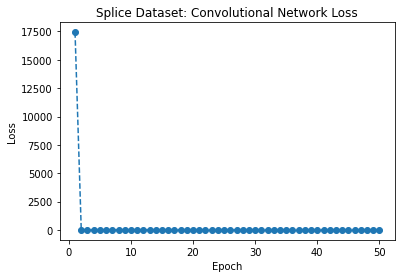

In [ ]:
FEATURE_SIZE = tokenized_seqs.shape[1]

class SimpleNet(nn.Module):
    def __init__(self, vocab_size, feature_size, num_classes=3):
        super(SimpleNet, self).__init__()
       
        self.vocab_size = vocab_size
        # embeded_dim: Dimension of word vectors.
        self.feature_size = feature_size

        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)

        self.fc1 = nn.Linear(feature_size, 1000)
        self.fc2 = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Creating net and training
net = SimpleNet(len(voc2ind), FEATURE_SIZE)
losses = train(net, train_dataloader, epochs = 50)

# Evaluation
plot_losses(losses, title = "Dataset: Convolutional Network Loss")
print_eval(net, train_dataloader, test_dataloader)
print()

### Experiments run with the model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train accuracy: 0.3386380458919319	(915/2702)
Test accuracy: 0.2857142857142857	(86/301)



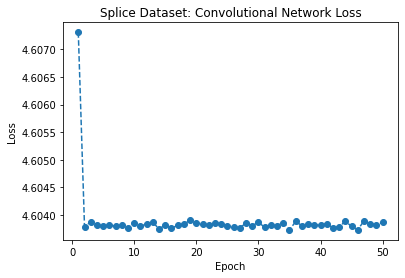

In [ ]:

ex = [['in_channels_conv1', 'out_channels_conv1', 'in_channels_conv2', 'out_channels_conv2', 'in_channels_fc1', 'kernel_size', 'stride'],
      [60, 40, 20, 40, 40, 3, 3], #1
      [60, 240, 120, 480, 480, 3, 3], #2 
      [60, 480, 240, 960, 960, 3, 3], #3
      [60, 480, 240, 960, 960, 6, 3], #4
      [60, 480, 240, 480, 240, 3, 3], #5
      [10, 80, 40, 160, 160, 6, 3], #6
      [60, 480, 240, 960, 960, 6, 3], #7
]
i = 5

FEATURE_SIZE = ex[i][0]

class DSC_by_CNN(nn.Module):
    def __init__(self, vocab_size, feature_size, num_classes=3):


        super(DSC_by_CNN, self).__init__()
       
        self.vocab_size = vocab_size
        # embeded_dim: Dimension of word vectors.
        self.feature_size = feature_size

        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        

        self.conv1 = nn.Conv1d(in_channels=ex[i][0],
                               out_channels=ex[i][1], 
                               kernel_size=ex[i][5],
                               stride = ex[i][6],
                               padding = 1)
        self.conv2 = nn.Conv1d(in_channels=ex[i][2],
                               out_channels=ex[i][3], 
                               kernel_size=ex[i][5],
                               stride = ex[i][6],
                               padding = 1)


        # Activation
        self.act = nn.ReLU()

        # Pooling
        self.pool = nn.MaxPool2d(3, 2, 1)

        # fully connected layer
        self.fc1 = nn.Linear(ex[i][4], 100)

        # dropout
        self.drop = nn.Dropout(p=0.5)


    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features        


    def forward(self, x):
       # b_input_ids = torch.tensor(b_input_ids).to(device).long()
        x = torch.tensor(x).to(torch.int64)

        # Encode. 
        # Output shape: (b, max_len, embedded_dim)
        x = self.encoder(x)

        # Output shape: (b, embedded_dim, max_len)
        x = x.permute(0, 2, 1)

        # convolutional layer 1
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool(x)

        # convolutional layer 2
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)

        # flattening
        x = x.view(-1, self.num_flat_features(x))

        # fully linear layer + dropout
        x = self.drop(x)
        # x = self.softm(x)
        x = self.fc1(x)

        return x

# Creating net and training
net = DSC_by_CNN(len(voc2ind), FEATURE_SIZE)
losses = train(net, train_dataloader, epochs=50, lr=0.01, decay = ex[i][-3])

# Evaluation
plot_losses(losses, title = "Dataset: Convolutional Network Loss")
print_eval(net, train_dataloader, test_dataloader)
print()

### Convolutional Model with 1D Max Pooling

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train accuracy: 0.32827535159141374	(887/2702)
Test accuracy: 0.3787375415282392	(114/301)



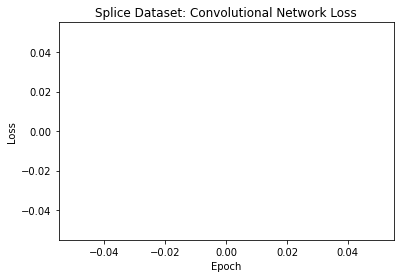

In [ ]:

ex = [['in_channels_conv1', 'out_channels_conv1', 'in_channels_conv2', 'out_channels_conv2', 'in_channels_fc1', 
       'kernel_size_conv1', 'stride_conv1', 'kenrnel_size_conv2', 'kernel_size_conv1'],
      [60, 480, 480, 1920, 1920, 3, 3, 3, 3], #1
]
i = 1

FEATURE_SIZE = ex[i][0]

class MP1_DSC_by_CNN(nn.Module):
    def __init__(self, vocab_size, feature_size, num_classes=2):


        super(MP1_DSC_by_CNN, self).__init__()
        
        self.vocab_size = vocab_size
        # embeded_dim: Dimension of word vectors.
        self.feature_size = feature_size

        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        

        self.conv1 = nn.Conv1d(in_channels=ex[i][0],
                               out_channels=ex[i][1], 
                               kernel_size=ex[i][5],
                               stride = ex[i][6],
                               padding = 1)
        self.conv2 = nn.Conv1d(in_channels=ex[i][2],
                               out_channels=ex[i][3], 
                               kernel_size=ex[i][7],
                               stride = ex[i][8],
                               padding = 1)


        # Activation
        self.act = nn.ReLU()

        # Pooling
        self.pool = nn.MaxPool1d(3, 2, 1)

        # fully connected layer
        self.fc1 = nn.Linear(ex[i][4], 100)

        # dropout
        self.drop = nn.Dropout(p=0.5)

        # softmax
        self.softm = nn.Softmax()


    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features        


    def forward(self, x):
        
        # b_input_ids = torch.tensor(b_input_ids).to(device).long()
        x = torch.tensor(x).to(torch.int64)

        # Encode. 
        # Output shape: (b, max_len, embedded_dim)
        x = self.encoder(x)

        
        # x = torch.flatten(x, 1)

       
        # Output shape: (b, embedded_dim, max_len)
        x = x.permute(0, 2, 1)

        # convolutional layer 1
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool(x)

        # convolutional layer 2
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)

        
        x = x.view(-1, self.num_flat_features(x))

       
        # print(x.shape)

        # fully linear layer + dropout
        x = self.drop(x)
        # x = self.softm(x)
        x = self.fc1(x)

        return x

# Creating net and training
net = MP1_DSC_by_CNN(len(voc2ind), FEATURE_SIZE)
losses = train(net, train_dataloader, epochs = 20, decay = ex[i][-3], lr=ex[i][-4], momentum=ex[i][-5])

# Evaluation
plot_losses(losses, title = "Dataset: Convolutional Network Loss")
print_eval(net, train_dataloader, test_dataloader)
print()

### Convolutional Model with 2D Max Pooling

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train accuracy: 0.32827535159141374	(887/2702)
Test accuracy: 0.3787375415282392	(114/301)



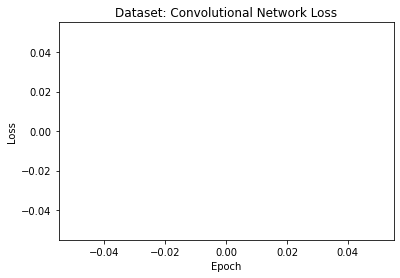

In [ ]:

ex = [['in_channels_conv1', 'out_channels_conv1', 'in_channels_conv2', 'out_channels_conv2', 'in_channels_fc1', 
       'kernel_size_conv1', 'stride_conv1', 'kenrnel_size_conv2', 'kernel_size_conv1'
       ],
      [2, 100, 50, 2800, 1400, 3, 3, 3, 3], 
]
i = 1

FEATURE_SIZE = ex[i][0]

class MP2_DSC_by_CNN(nn.Module):
    def __init__(self, vocab_size, feature_size, num_classes=2):


        super(MP2_DSC_by_CNN, self).__init__()
        # UM?
        self.vocab_size = vocab_size
        # embeded_dim: Dimension of word vectors.
        self.feature_size = feature_size

        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        

        self.conv1 = nn.Conv1d(in_channels=ex[i][0],
                               out_channels=ex[i][1], 
                               kernel_size=ex[i][5],
                               stride = ex[i][6],
                               padding = 1)
        self.conv2 = nn.Conv1d(in_channels=ex[i][2],
                               out_channels=ex[i][3], 
                               kernel_size=ex[i][7],
                               stride = ex[i][8],
                               padding = 1)


        # Activation
        self.act = nn.ReLU()

        # Pooling
        self.pool = nn.MaxPool2d(3, 2, 1)

        # fully connected layer
        self.fc1 = nn.Linear(ex[i][4], 100)
        self.fc2 = nn.Linear(100, num_classes)

        # dropout
        self.drop = nn.Dropout(p=0.5)

        # softmax
        self.softm = nn.Softmax()



    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features        


    def forward(self, x):
       
        # b_input_ids = torch.tensor(b_input_ids).to(device).long()
        x = torch.tensor(x).to(torch.int64)

        # Encode. 
        # Output shape: (b, max_len, embedded_dim)
        x = self.encoder(x)

        # idk flatten it?
        # x = torch.flatten(x, 1)

       
        # Output shape: (b, embedded_dim, max_len)
        x = x.permute(0, 2, 1)

        # convolutional layer 1
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool(x)

        # convolutional layer 2
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)

        
        x = x.view(-1, self.num_flat_features(x))

       
        # print(x.shape)

        # fully linear layer + dropout
        x = self.drop(x)
        # x = self.softm(x)
        x = self.fc1(x)
        # x = self.fc2(x)

        return x

# Creating net and training
net = MP2_DSC_by_CNN(len(voc2ind), FEATURE_SIZE)
losses = train(net, train_dataloader, epochs = 150, decay = ex[i][-3], lr=ex[i][-4], momentum=ex[i][-5])

# Evaluation
plot_losses(losses, title = "Dataset: Convolutional Network Loss")
print_eval(net, train_dataloader, test_dataloader)
print()